In [2]:
import numpy as np
from numpy import ma
import math
import scipy
import os
from IPython.display import Image
from tqdm import tqdm

from netCDF4 import Dataset

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec

# from matplotlib.mlab import bivariate_normal

NA = 6.022e+23

In [3]:

# Eulerian 2*2.5
FILEDIR3 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/Final_simulation_continuous_injection/gc_2x25_eulerian_final'
NcFile3   = Dataset(FILEDIR3+'/OutputDir/GEOSChem.SpeciesConc.20150101_0010z.nc4','r',format='NETCDF4_CLASSIC')

lat3             = NcFile3.variables['lat'][:]
lon3             = NcFile3.variables['lon'][:]
EU3              = NcFile3.variables['SpeciesConc_PASV_EU']

GC_AREA3 = NcFile3.variables['AREA'][:,:];



# lagrange: 2*2.5
FILEDIR0 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/Final_simulation_continuous_injection/Sensitive_test/Splitting_length/gc_2x25_lagrange_Dx'
NcFile0   = Dataset(FILEDIR0+'/OutputDir/GEOSChem.SpeciesConc.20150101_0010z.nc4','r',format='NETCDF4_CLASSIC')

lat0             = NcFile0.variables['lat'][:]
lon0             = NcFile0.variables['lon'][:]
LA0              = NcFile0.variables['SpeciesConc_PASV_LA'][:,:,:,:]
LA0_3            = NcFile0.variables['SpeciesConc_PASV_LA3'][:,:,:,:]

LA0 = LA0 + LA0_3

GC_AREA0 = NcFile0.variables['AREA'][:,:];


In [4]:

Nx3 = len(EU3[0,0,0,:])
Ny3 = len(EU3[0,0,:,0])
Nz3 = len(EU3[0,:,0,0])
Nt3 = len(EU3[:,0,0,0])

Nx0 = len(LA0[0,0,0,:])
Ny0 = len(LA0[0,0,:,0])
Nz0 = len(LA0[0,:,0,0])
Nt0 = len(LA0[:,0,0,0])

EU3

<class 'netCDF4._netCDF4.Variable'>
float32 SpeciesConc_PASV_EU(time, lev, lat, lon)
    long_name: Dry mixing ratio of species PASV_EU
    units: mol mol-1 dry
    averaging_method: instantaneous
unlimited dimensions: time
current shape = (30, 72, 91, 144)
filling off

In [5]:
#------------------------------------------------
# total air mass in each grid  ------------------
#------------------------------------------------

# 2x2.5
AD_file3 = Dataset(FILEDIR3+'/OutputDir/GEOSChem.StateMet.20150101_0010z.nc4','r',format='NETCDF4_CLASSIC')
GC_AD3   = AD_file3.variables['Met_AD']

# 2x2.5
AD_file0 = Dataset(FILEDIR0+'/OutputDir/GEOSChem.StateMet.20150101_0010z.nc4','r',format='NETCDF4_CLASSIC')
GC_AD0   = AD_file0.variables['Met_AD']


In [6]:
GC_AD0

<class 'netCDF4._netCDF4.Variable'>
float32 Met_AD(time, lev, lat, lon)
    long_name: Dry air mass
    units: kg
    averaging_method: instantaneous
unlimited dimensions: time
current shape = (30, 72, 91, 144)
filling off

In [7]:
del AD_file0, AD_file3

In [8]:
### change unit, do average 

# 2.0x2.5
EU3_molec = EU3[:,:,:,:]*0.0
for i in range(Nt3):
    EU3_molec[i,:,:,:] = EU3[i,:,:,:]*(GC_AD3[i,:,:,:]*1000.0/28.97)*NA # [mol/mol] to [molec]
    
EU3_Zsum = np.sum(EU3_molec[:,:,:,:], axis=1)
for i in range(Nt3):
    EU3_Zsum[i,:,:] = EU3_Zsum[i,:,:]/GC_AREA3[:,:]/1e4 # [molec/cm2]
     
EU3_Zsum_Xmean = np.mean(EU3_Zsum[:,:,:], axis=2)


# lagrange: 2.0x2.5
LA0_molec = LA0[:,:,:,:]*0.0
for i in range(Nt0):
    LA0_molec[i,:,:,:] = LA0[i,:,:,:]*(GC_AD0[i,:,:,:]*1000.0/28.97)*NA

LA0_Zsum = np.sum(LA0_molec[:,:,:,:], axis=1)
for i in range(Nt0):
    LA0_Zsum[i,:,:]   = LA0_Zsum[i,:,:]/GC_AREA0[:,:]/1e4
    
LA0_Zsum_Xmean = np.mean(LA0_Zsum[:,:,:], axis=2)


print( np.sum(EU3_molec[Nt3-1,:,:,:]) )
print( np.sum(LA0_molec[Nt0-1,:,:,:]) )
del EU3, LA0

1.0510172e+32
1.0486555e+32


Total mass [molec] in the end: 
GEOS-Chem         = 1.8455115411646054e+17
plume model 2*2.5 = 1.831916251685847e+17


30

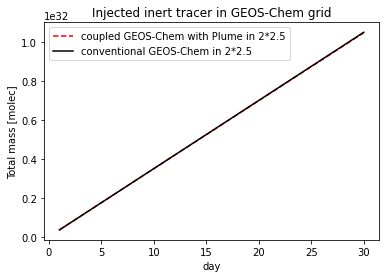

In [9]:


t = Nt0-1
print(f'Total mass [molec] in the end: ')
print(f'GEOS-Chem         = {np.sum(EU3_Zsum[t,:,:])}')
print(f'plume model 2*2.5 = {np.sum(LA0_Zsum[t,:,:])}')

LA0_mass = []
EU3_mass = []


days = []

for i in range(Nt0):
    days.append(i+1);
    LA0_mass.append(np.sum(LA0_molec[i,:,:,:]))
    EU3_mass.append(np.sum(EU3_molec[i,:,:,:]))
    
plt.plot(days, LA0_mass, 'r--', label='coupled GEOS-Chem with Plume in 2*2.5');

plt.plot(days, EU3_mass, 'k', label='conventional GEOS-Chem in 2*2.5');

plt.title('Injected inert tracer in GEOS-Chem grid');
plt.xlabel('day');
plt.ylabel('Total mass [molec]');
plt.legend();

days[-1]

In [10]:
# plot  -----------------------------------------
#------------------------------------------------
# time step for ploting is 24 hours (once every day)
print(Nt0)

X_max = np.max(LA0_Zsum_Xmean[:,:],axis=(0,1)) # 16.5e+11;

# Nt0=1
for i in tqdm(np.arange(0,Nt0,1)):
    fig = plt.figure(figsize=(15,3.3), dpi=150);
    gs = gridspec.GridSpec(1, 11, figure=fig)
    plt.suptitle('Day: '+str(i+1), fontsize=16);
    
    
    # (1) for Lagrange ============================================================
    projection=ccrs.PlateCarree()
    ax1 = fig.add_subplot(gs[0, 0:4], projection=ccrs.PlateCarree())
#     ax1 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree());
    ax1.set_global()
    
    ax1.gridlines(x_inline=True)    
    ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
    ax1.set_yticks(np.linspace(-90, 90, 7), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    

#     z = ma.masked_where(LA_Zsum[i,:,:] <= 1e-10, LA_Zsum[i,:,:])

    levels =  np.arange(0.5,10,1)*1e13

    norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)
    
    data = LA0_Zsum[i,:,:]
    cyclic_data = add_cyclic_point(data)
    data, lon0_cyclic = add_cyclic_point(data, coord=lon0)
    
    ax1_contours = ax1.contourf(lon0_cyclic, lat0, data, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("Reds"), extend="max");
    
    cb1 = plt.colorbar(ax1_contours, ax=ax1)
    cb1.ax.tick_params(labelsize=11)
    cb1.set_label('[$molec \cdot cm^{-2}$]', fontsize=12)
    
    ax1.coastlines();
    ax1.set_title('The coupled PiG model', fontsize=13);
    ax1.set_title('(a)', fontsize=13, loc='left');

    
     # (2) for EU ==================================================================
    ax3 = fig.add_subplot(gs[0, 4:8], projection=ccrs.PlateCarree())
#     ax3 = plt.subplot(1, 3, 2, projection=ccrs.PlateCarree());
    ax3.set_global()
    
    ax3.gridlines(x_inline=True)    
    ax3.set_xticks(np.linspace(-180, 180, 7), crs=projection)
    ax3.set_yticks(np.linspace(-90, 90, 7), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax3.xaxis.set_major_formatter(lon_formatter)
    ax3.yaxis.set_major_formatter(lat_formatter)
    
#     z = ma.masked_where(EU_Zsum[i,:,:] <= 1e-5, EU_Zsum[i,:,:])
    data = EU3_Zsum[i,:,:]
    cyclic_data = add_cyclic_point(data)
    data, lon3_cyclic = add_cyclic_point(data, coord=lon3)
    
    ax3_contours = ax3.contourf(lon3_cyclic, lat3, data, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("Reds"), extend="max");


    cb3 = plt.colorbar(ax3_contours, ax=ax3)
    cb3.ax.tick_params(labelsize=11)
    cb3.set_label('[$molec \cdot cm^{-2}$]', fontsize=12)
    
    ax3.coastlines();
    ax3.set_title('(b)', fontsize=13, loc='left');
    ax3.set_title('The GEOS-Chem model', fontsize=13);
    
    
    
    # (3) for GOES distribution ===================================================
    ax4 = fig.add_subplot(gs[0, 8:11])
#     ax4 = plt.subplot(1,3,3);
    
    ax4.plot(LA0_Zsum_Xmean[i,:], lat0, 'r', alpha=0.8, label='The coupled PiG model');
    ax4.plot(EU3_Zsum_Xmean[i,:], lat3, 'b--', label='The GEOS-Chem model');
    

    
    
    ax4.set_xlim(0,X_max);
    ax4.set_ylim(-90,90);

    tick_locs = [-90, -60, -30, 0, 30, 60, 90]
    tick_lbls = ['90$^\circ$S','60$^\circ$S','30$^\circ$S','0$^\circ$','30$^\circ$N','60$^\circ$N','90$^\circ$N']
    ax4.set_yticks(np.array(tick_locs))
    ax4.set_yticklabels(tick_lbls,fontsize=12)
    
    ax4.set_title('(c)', fontsize=13, loc='left');
    ax4.set_title('Zonal mean concentration', fontsize=13);

    ax4.set_xlabel('Concentration [$molec \cdot cm^{-2}$]', fontsize=12);
    ax4.tick_params(axis='x', labelsize=11)  # to Set Matplotlib Tick Labels Font Size
    ax4.tick_params(axis='y', labelsize=11)
    ax4.legend()
    
    
    plt.tight_layout()
    plt.savefig(str(i+1)+'_xy2.png', transparent=False, facecolor='w', edgecolor='w');
    plt.close();
    plt.clf();
    plt.cla();
        
plt.close();

  0%|          | 0/30 [00:00<?, ?it/s]

30


100%|██████████| 30/30 [00:31<00:00,  1.06s/it]


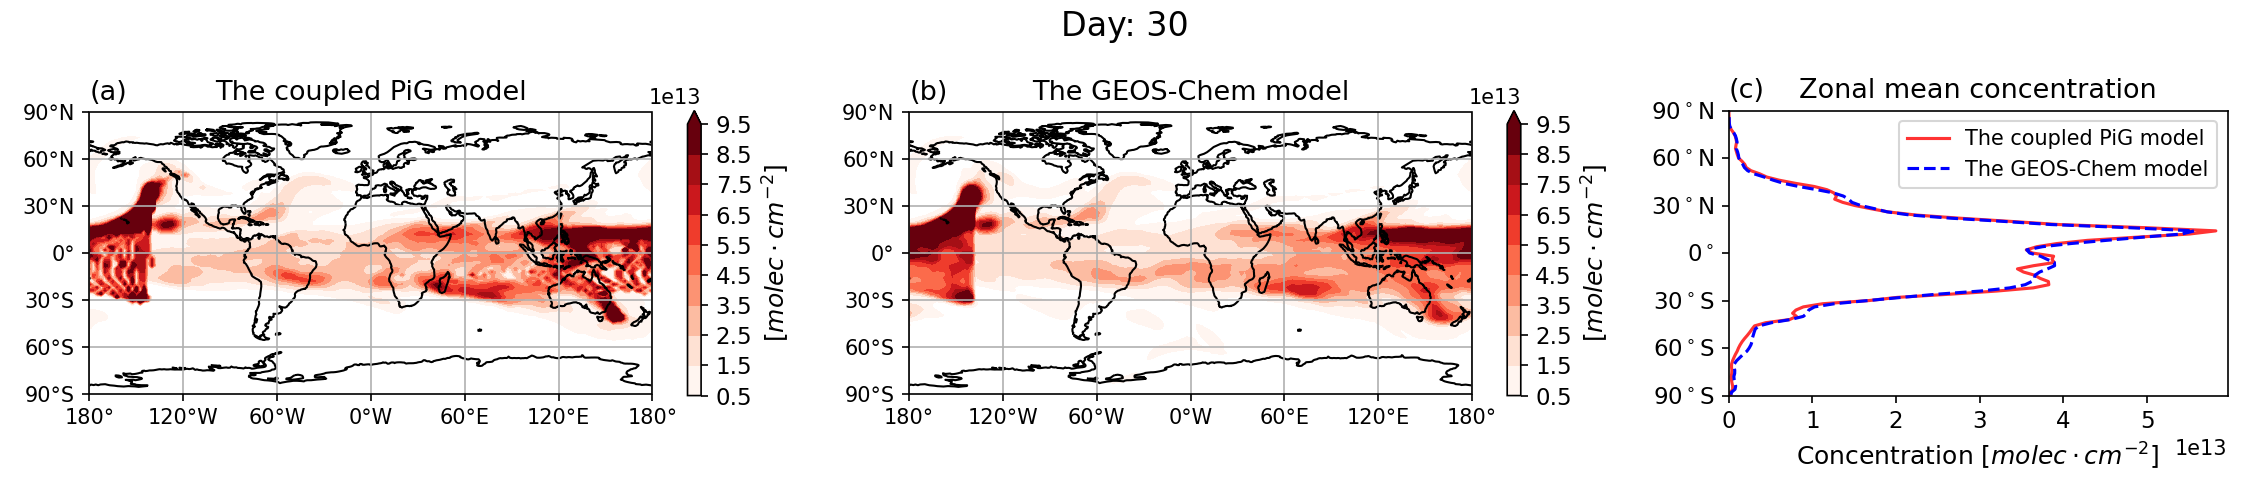

In [11]:
Image(filename=f'30_xy2.png')

In [15]:
os.system("./png2gif2.sh")

32512

In [12]:
# calculate the average and std for the curves at last time step

time = Nt1-1

# LA1_Zsum_Xmean[time,:]
# LA2_Zsum_Xmean[time,:]

# EU1_Zsum_Xmean[time,:]
# EU2_Zsum_Xmean[time,:]

LA1_mean = np.mean(LA1_Zsum_Xmean[time,:])
LA1_std = np.std(LA1_Zsum_Xmean[time,:])

LA2_mean = np.mean(LA2_Zsum_Xmean[time,:])
LA2_std = np.std(LA2_Zsum_Xmean[time,:])

EU1_mean = np.mean(EU1_Zsum_Xmean[time,:])
EU1_std = np.std(EU1_Zsum_Xmean[time,:])

EU2_mean = np.mean(EU2_Zsum_Xmean[time,:])
EU2_std = np.std(EU2_Zsum_Xmean[time,:])

NameError: name 'Nt1' is not defined